In [3]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("/n/home11/sambt/LIGO/gwak/gwak/train/")
from gwak.train.dataloader import SignalDataloader
from pathlib import Path
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import lightning.pytorch as pl
import yaml
from tqdm import tqdm
from ml4gw.transforms import SpectralDensity, Whiten
from sklearn.metrics import roc_curve, auc
from tqdm import tqdm

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
#data_dir = "/n/netscratch/iaifi_lab/Lab/emoreno/O4_MDC_background/LV/"
data_dir = '/n/holystore01/LABS/iaifi_lab/Lab/sambt/LIGO/O4_MDC_background/HL/'
sample_rate = 4096
kernel_length = 1.0
psd_length = 64
fduration = 1
fftlength = 2
batch_size = 1024
batches_per_epoch = 500
num_workers = 4
data_saving_file = None
duration = fduration + kernel_length

from gwak.data.prior import SineGaussianBBC, LAL_BBHPrior, GaussianBBC, CuspBBC, KinkBBC, KinkkinkBBC, WhiteNoiseBurstBBC
from ml4gw.waveforms import SineGaussian, IMRPhenomPv2, Gaussian, GenerateString, WhiteNoiseBurst

signal_classes = [
    "SineGaussian",
    "BBH",
    "Gaussian",
    "Cusp",
    "Kink",
    "KinkKink",
    "WhiteNoiseBurst",
    "CCSN",
    "Background",
    "Glitch"
]
priors = [
    SineGaussianBBC(),
    LAL_BBHPrior(),
    GaussianBBC(),
    CuspBBC(),
    KinkBBC(),
    KinkkinkBBC(),
    WhiteNoiseBurstBBC(),
    None,
    None,
    None
]
waveforms = [
    SineGaussian(
        sample_rate=sample_rate,
        duration=duration
    ),
    IMRPhenomPv2(),
    Gaussian(
        sample_rate=sample_rate,
        duration=duration
    ),
    GenerateString(
        sample_rate=sample_rate
    ),
    GenerateString(
        sample_rate=sample_rate
    ),
    GenerateString(
        sample_rate=sample_rate
    ),
    WhiteNoiseBurst(
        sample_rate=sample_rate,
        duration=duration
    ),
    None,
    None,
    None
]
extra_kwargs = [
    None,
    {"ringdown_duration":0.9},
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None
]

In [71]:
loader = SignalDataloader(signal_classes,
    priors,
    waveforms,
    extra_kwargs,
    data_dir=data_dir,
    sample_rate=sample_rate,
    kernel_length=kernel_length,
    psd_length=psd_length,
    fduration=fduration,
    fftlength=fftlength,
    batch_size=batch_size,
    batches_per_epoch=batches_per_epoch,
    num_workers=num_workers,
    ifos="HL",
    glitch_root="/n/netscratch/iaifi_lab/Lab/emoreno/O4_MDC_background/omicron/HL/"
)

ifos are ['H1', 'L1']
data dir is /n/holystore01/LABS/iaifi_lab/Lab/sambt/LIGO/O4_MDC_background/HL/


In [6]:
train_loader = loader.train_dataloader()
val_loader = loader.val_dataloader()

/n/holystore01/LABS/iaifi_lab/Users/sambt/mamba/envs/gwak/lib/python3.11/site-packages/ml4gw/dataloading/hdf5_dataset.py:162: ContiguousHdf5Warning: /n/holystore01/LABS/iaifi_lab/Lab/sambt/LIGO/O4_MDC_background/HL/background-1401696321-8160.h5 stored contiguously – slower I/O
  warnings.warn(f"{fname} stored contiguously – slower I/O", ContiguousHdf5Warning)
/n/holystore01/LABS/iaifi_lab/Users/sambt/mamba/envs/gwak/lib/python3.11/site-packages/ml4gw/dataloading/hdf5_dataset.py:162: ContiguousHdf5Warning: /n/holystore01/LABS/iaifi_lab/Lab/sambt/LIGO/O4_MDC_background/HL/background-1402046551-23281.h5 stored contiguously – slower I/O
  warnings.warn(f"{fname} stored contiguously – slower I/O", ContiguousHdf5Warning)
/n/holystore01/LABS/iaifi_lab/Users/sambt/mamba/envs/gwak/lib/python3.11/site-packages/ml4gw/dataloading/hdf5_dataset.py:162: ContiguousHdf5Warning: /n/holystore01/LABS/iaifi_lab/Lab/sambt/LIGO/O4_MDC_background/HL/background-1402080387-3080.h5 stored contiguously – slower I

In [7]:
# load encoder model
from cl_models import Crayon, Contour
model_ckpt = "/n/home11/sambt/LIGO/gwak/gwak/output/resnet_kl1.0_bs512_noClassifier_noMultiSG_fixedWNBGaus_HL/gwak2_embeddings/hf60gyfq/checkpoints/last.ckpt"
wgts = torch.load(model_ckpt,map_location='cpu')
module = Contour(**wgts['hyper_parameters']['init_args'])
module.load_state_dict(wgts['state_dict'])
module = module.to(device)
module = module.eval()

/tmp/ipykernel_3024516/798770459.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  wgts = torch.load(model_ckpt,map_location='cpu')


In [9]:
def frequency_cos_similarity(batch):
    H = torch.fft.rfft(batch[:, 0, :], dim=-1)
    L = torch.fft.rfft(batch[:, 1, :], dim=-1)
    numerator = torch.sum(H * torch.conj(L), dim=-1)
    norm_H = torch.linalg.norm(H, dim=-1)
    norm_L = torch.linalg.norm(L, dim=-1)
    rho_complex = numerator / (norm_H * norm_L + 1e-8)
    rho_real = torch.real(rho_complex).unsqueeze(-1)
    return rho_real

In [8]:
train_iter = iter(train_loader)
ntarg = 100_000
n_iter = (ntarg // batch_size) + 1

embeddings = []
for i in tqdm(range(n_iter)):
    batch = next(train_iter)
    batch = [b.to(device) for b in batch]
    batch,labels = loader.on_after_batch_transfer(batch,None,local_test=True)
    with torch.no_grad():
        e = module.model(batch).cpu().numpy()
        embeddings.append(e)
    del batch, labels
    torch.cuda.empty_cache()
embeddings = np.concatenate(embeddings,axis=0)

100%|██████████| 98/98 [30:11<00:00, 18.49s/it]


In [10]:
mean = np.mean(embeddings,axis=0)
std = np.std(embeddings,axis=0)
np.savez("embeddings_resnet_kl1.0_bs512_noClassifier_noMultiSG_fixedWNBGaus_HL.npz",embeddings=embeddings,mean=mean,std=std)

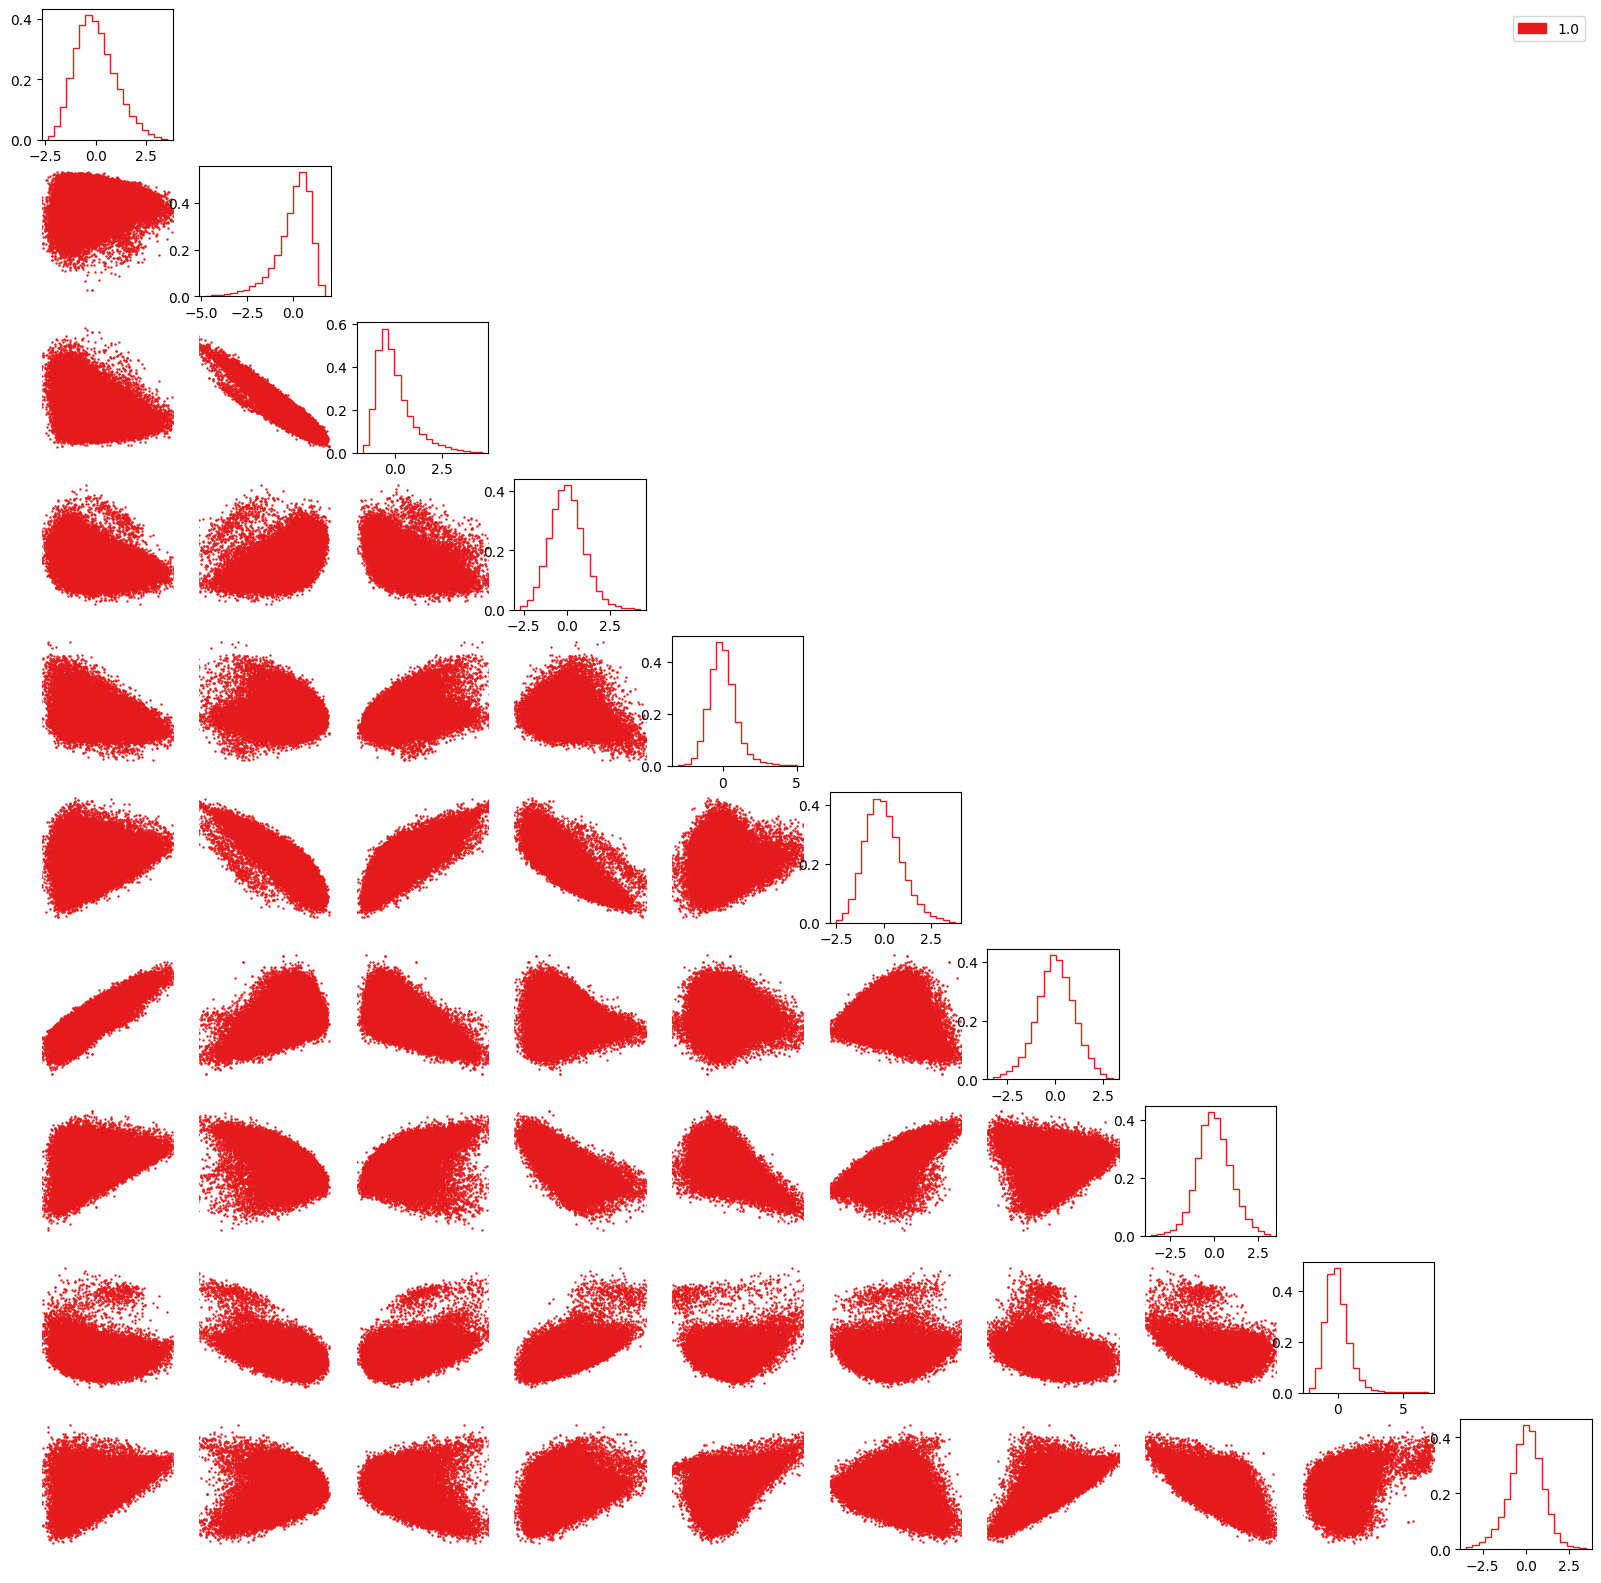

In [19]:
from plotting import make_corner
f = np.load("embeddings_resnet_kl1.0_bs512_noClassifier_noMultiSG_fixedWNBGaus_HL.npz")
embeddings = f['embeddings']
embeddings = (embeddings-f['mean'])/f['std']
make_corner(embeddings,labels=np.ones(len(embeddings)))

# train flow

In [22]:
from sklearn.model_selection import train_test_split

f = np.load("embeddings_resnet_kl1.0_bs512_noClassifier_noMultiSG_fixedWNBGaus_HL.npz")
embeddings = f['embeddings']
embeddings = (embeddings-f['mean'])/f['std']

xtrain,xtest = train_test_split(embeddings,train_size=0.8)

from torch.utils.data import Dataset, TensorDataset, DataLoader
train_dset = TensorDataset(torch.tensor(xtrain))
test_dset = TensorDataset(torch.tensor(xtest))
train_loader = DataLoader(train_dset,batch_size=512,shuffle=True)
test_loader = DataLoader(test_dset,batch_size=512,shuffle=True)

In [28]:
from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.permutations import ReversePermutation
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.autoregressive import MaskedPiecewiseRationalQuadraticAutoregressiveTransform

num_features = 10
num_layers = 4
num_blocks_per_layer = 4
hidden_features = 160
tail_bound = 6
num_bins = 40
tails = 'linear'

transforms = []
for i in range(num_layers):
    transforms.append(MaskedPiecewiseRationalQuadraticAutoregressiveTransform(
        features=num_features,
        hidden_features=hidden_features,
        num_bins=num_bins,
        num_blocks=num_blocks_per_layer,
        tail_bound=tail_bound, 
        tails=tails
    ))
    
    if i < num_layers 1:
        transforms.append(ReversePermutation(num_features))

model = Flow(
            transform=CompositeTransform(transforms),
            distribution=StandardNormal([num_features])
        )
model = model.to(device)

Epoch 1


100%|██████████| 40/40 [00:00<00:00, 86.68it/s]


l_train = 5.14785, l_val = 3.46620
Epoch 2


100%|██████████| 40/40 [00:00<00:00, 81.77it/s]


l_train = 3.11126, l_val = 2.97788
Epoch 3


100%|██████████| 40/40 [00:00<00:00, 82.05it/s]


l_train = 2.96080, l_val = 2.84585
Epoch 4


100%|██████████| 40/40 [00:00<00:00, 81.34it/s]


l_train = 2.89018, l_val = 2.80917
Epoch 5


100%|██████████| 40/40 [00:00<00:00, 84.98it/s]


l_train = 2.84701, l_val = 2.79595
Epoch 6


100%|██████████| 40/40 [00:00<00:00, 82.04it/s]


l_train = 2.81256, l_val = 2.81374
Epoch 7


100%|██████████| 40/40 [00:00<00:00, 86.52it/s]


l_train = 2.81347, l_val = 2.74548
Epoch 8


100%|██████████| 40/40 [00:00<00:00, 85.72it/s]


l_train = 2.78258, l_val = 2.76863
Epoch 9


100%|██████████| 40/40 [00:00<00:00, 83.33it/s]


l_train = 2.76822, l_val = 2.74099
Epoch 10


100%|██████████| 40/40 [00:00<00:00, 81.51it/s]


l_train = 2.76486, l_val = 2.75926
Epoch 11


100%|██████████| 40/40 [00:00<00:00, 84.96it/s]


l_train = 2.75844, l_val = 2.75699
Epoch 12


100%|██████████| 40/40 [00:00<00:00, 85.46it/s]


l_train = 2.74037, l_val = 2.76614
Epoch 13


100%|██████████| 40/40 [00:00<00:00, 82.27it/s]


l_train = 2.71755, l_val = 2.75787
Epoch 14


100%|██████████| 40/40 [00:00<00:00, 84.92it/s]


l_train = 2.70450, l_val = 2.75201
Epoch 15


100%|██████████| 40/40 [00:00<00:00, 82.18it/s]


l_train = 2.70037, l_val = 2.75210
Epoch 16


100%|██████████| 40/40 [00:00<00:00, 82.77it/s]


l_train = 2.70288, l_val = 2.68761
Epoch 17


100%|██████████| 40/40 [00:00<00:00, 84.55it/s]


l_train = 2.68820, l_val = 2.74631
Epoch 18


100%|██████████| 40/40 [00:00<00:00, 85.92it/s]


l_train = 2.67174, l_val = 2.69699
Epoch 19


100%|██████████| 40/40 [00:00<00:00, 86.68it/s]


l_train = 2.65965, l_val = 2.69498
Epoch 20


100%|██████████| 40/40 [00:00<00:00, 87.33it/s]


l_train = 2.65966, l_val = 2.67357
Epoch 21


100%|██████████| 40/40 [00:00<00:00, 81.84it/s]


l_train = 2.64251, l_val = 2.71197
Epoch 22


100%|██████████| 40/40 [00:00<00:00, 82.11it/s]


l_train = 2.65135, l_val = 2.67101
Epoch 23


100%|██████████| 40/40 [00:00<00:00, 82.52it/s]


l_train = 2.62832, l_val = 2.66098
Epoch 24


100%|██████████| 40/40 [00:00<00:00, 85.69it/s]


l_train = 2.61817, l_val = 2.65005
Epoch 25


100%|██████████| 40/40 [00:00<00:00, 82.13it/s]


l_train = 2.60857, l_val = 2.68762
Epoch 26


100%|██████████| 40/40 [00:00<00:00, 84.79it/s]


l_train = 2.60259, l_val = 2.66082
Epoch 27


100%|██████████| 40/40 [00:00<00:00, 75.34it/s]


l_train = 2.59366, l_val = 2.66383
Epoch 28


100%|██████████| 40/40 [00:00<00:00, 75.98it/s]


l_train = 2.58317, l_val = 2.68956
Epoch 29


100%|██████████| 40/40 [00:00<00:00, 56.24it/s]


l_train = 2.57012, l_val = 2.66414
Epoch 30


100%|██████████| 40/40 [00:00<00:00, 84.94it/s]


l_train = 2.56768, l_val = 2.63567
Epoch 31


100%|██████████| 40/40 [00:00<00:00, 84.41it/s]


l_train = 2.55730, l_val = 2.65327
Epoch 32


100%|██████████| 40/40 [00:00<00:00, 85.17it/s]


l_train = 2.54711, l_val = 2.63211
Epoch 33


100%|██████████| 40/40 [00:00<00:00, 57.35it/s]


l_train = 2.53653, l_val = 2.64746
Epoch 34


100%|██████████| 40/40 [00:00<00:00, 81.87it/s]


l_train = 2.53114, l_val = 2.63409
Epoch 35


100%|██████████| 40/40 [00:00<00:00, 78.29it/s]


l_train = 2.51634, l_val = 2.61934
Epoch 36


100%|██████████| 40/40 [00:00<00:00, 85.38it/s]


l_train = 2.51232, l_val = 2.63275
Epoch 37


100%|██████████| 40/40 [00:00<00:00, 58.90it/s]


l_train = 2.50577, l_val = 2.62244
Epoch 38


100%|██████████| 40/40 [00:00<00:00, 81.65it/s]


l_train = 2.49433, l_val = 2.62621
Epoch 39


100%|██████████| 40/40 [00:00<00:00, 81.94it/s]


l_train = 2.48935, l_val = 2.63607
Epoch 40


100%|██████████| 40/40 [00:00<00:00, 81.70it/s]


l_train = 2.47750, l_val = 2.62835
Epoch 41


100%|██████████| 40/40 [00:00<00:00, 56.36it/s]


l_train = 2.47266, l_val = 2.63741
Epoch 42


100%|██████████| 40/40 [00:00<00:00, 82.01it/s]


l_train = 2.46486, l_val = 2.61506
Epoch 43


100%|██████████| 40/40 [00:00<00:00, 82.79it/s]


l_train = 2.45954, l_val = 2.62429
Epoch 44


100%|██████████| 40/40 [00:00<00:00, 85.47it/s]


l_train = 2.45256, l_val = 2.62482
Epoch 45


100%|██████████| 40/40 [00:00<00:00, 57.44it/s]


l_train = 2.44782, l_val = 2.62337
Epoch 46


100%|██████████| 40/40 [00:00<00:00, 86.05it/s]


l_train = 2.44333, l_val = 2.63135
Epoch 47


100%|██████████| 40/40 [00:00<00:00, 78.44it/s]


l_train = 2.44013, l_val = 2.61516
Epoch 48


100%|██████████| 40/40 [00:00<00:00, 85.50it/s]


l_train = 2.43741, l_val = 2.62287
Epoch 49


100%|██████████| 40/40 [00:00<00:00, 85.76it/s]


l_train = 2.43575, l_val = 2.62272
Epoch 50


100%|██████████| 40/40 [00:00<00:00, 84.59it/s]

l_train = 2.43419, l_val = 2.61909


Text(0, 0.5, 'loss')

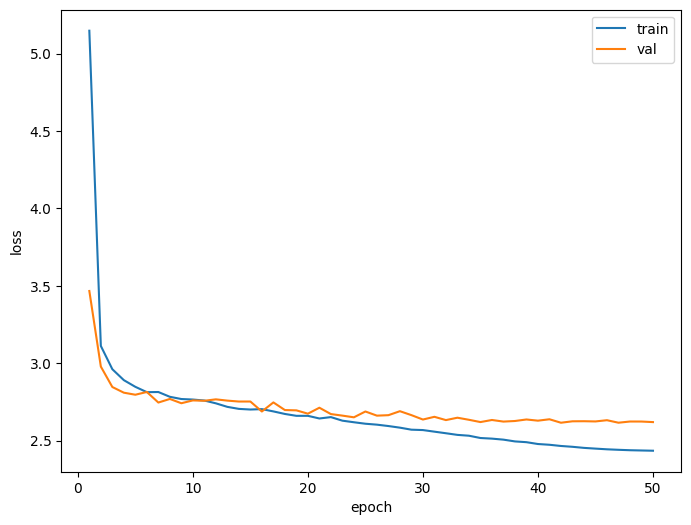

In [31]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
lr = 1e-3
n_epoch = 50
optimizer = AdamW(model.parameters(),lr=lr)

lr_min = 1e-5
scheduler = CosineAnnealingLR(optimizer,T_max=n_epoch*len(train_loader),eta_min=lr_min)


best_train_loss = 99999999
best_val_loss = 99999999
train_losses = []
val_losses = []
best_ckpt = None
patience = 0
patience_limit = 10
for iep in range(n_epoch):
    ep_losses = []
    print(f"Epoch {iep+1}")
    for x, in tqdm(train_loader):
        optimizer.zero_grad()
        loss = -model.log_prob(inputs=x.to(device)).mean()
        loss.backward()
        optimizer.step()
        scheduler.step()
        ep_losses.append(loss.item())
    ep_losses = np.mean(ep_losses)
    if ep_losses < best_train_loss:
        best_train_loss = ep_losses
    train_losses.append(ep_losses)
    
    ep_losses = []
    for x, in tqdm(test_loader):
        with torch.no_grad():
            loss = -model.log_prob(inputs=x.to(device)).mean()
            ep_losses.append(loss.item())
    ep_losses = np.mean(ep_losses)
    if ep_losses < best_val_loss:
        best_val_loss = ep_losses
        best_ckpt = model.state_dict()
        patience = 0
    else:
        patience += 1
    val_losses.append(ep_losses)
    
    print(f"l_train = {train_losses[-1]:.5f}, l_val = {val_losses[-1]:.5f}")
    
    if patience >= patience_limit:
        print("Not improving val loss, terminating")
        break

model.load_state_dict(best_ckpt)
        
t=np.arange(n_epoch)+1
plt.figure(figsize=(8,6))
plt.plot(t,train_losses,label='train')
plt.plot(t,val_losses,label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')

In [34]:
model.load_state_dict(best_ckpt)

def plotDensity(model,val_data,log=False):
    with torch.no_grad():
        samples = model.sample(val_data.shape[0]).cpu().numpy()
    plt.figure(figsize=(15,20))
    for index in range(val_data.shape[1]):
        plt.subplot(4,3,index+1)
        n, bins, patches = plt.hist(val_data[:, index], bins=50, histtype='step', label='Truth')
        plt.hist(samples[:, index], bins=bins, histtype='step', label='NF Density')
        if index == 0:
            plt.legend(loc='best')
        plt.title(f"Axis {index}")
    plt.show()
    torch.cuda.empty_cache()

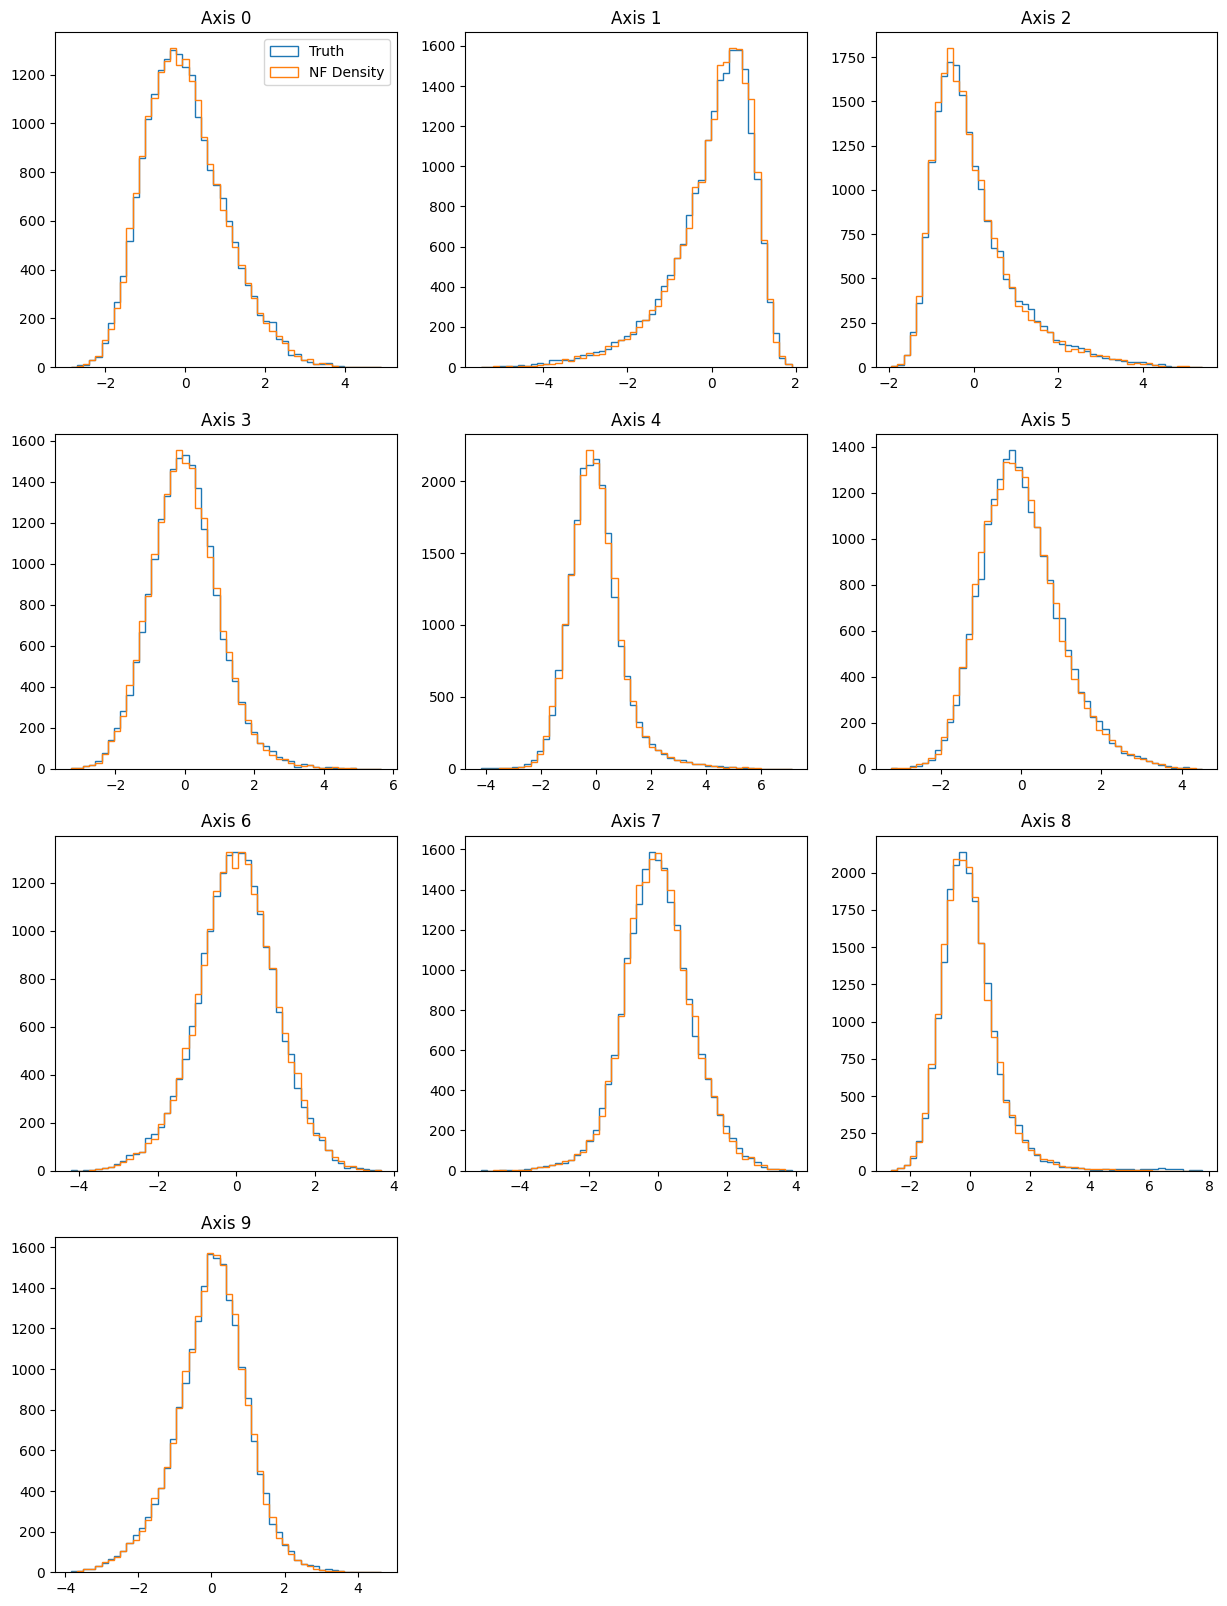

In [35]:
plotDensity(model,xtest)

In [39]:
losses = []
for x, in test_loader:
    with torch.no_grad():
        losses.append(-model.log_prob(x.to(device)).cpu().numpy())
losses = np.concatenate(losses)

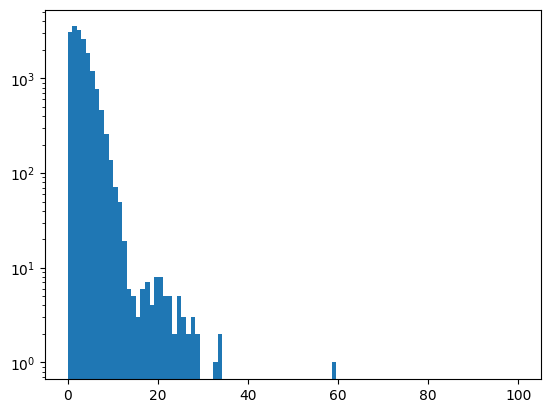

In [46]:
h=plt.hist(losses,bins=np.linspace(0,100,100))
plt.yscale('log')

# make a combined model

In [52]:
model = model.eval()
module = module.eval()
module.model.eval()

ResNet1D(
  (conv1): Conv1d(2, 64, kernel_size=(7,), stride=(2,), padding=(3,), bias=False)
  (bn1): GroupNorm(64, 64, eps=1e-05, affine=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (residual_layers): ModuleList(
    (0): Sequential(
      (0): BasicBlock(
        (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (bn1): GroupNorm(64, 64, eps=1e-05, affine=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (bn2): GroupNorm(64, 64, eps=1e-05, affine=True)
      )
      (1): BasicBlock(
        (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (bn1): GroupNorm(64, 64, eps=1e-05, affine=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (bn2): GroupNorm(64, 64, ep

In [56]:
import torch.nn as nn
class FlowWrapper(nn.Module):
    def __init__(self, flow):
        super().__init__()
        self.flow = flow

    def forward(self, x):
        return -self.flow.log_prob(x)

class CombinedModel(nn.Module):
    def __init__(self,embedder,flow,mean,std,mins,maxes):
        super().__init__()
        self.embedder = embedder
        self.flow = flow
        self.mean = torch.tensor(mean)
        self.std = torch.tensor(std)
        self.mins = torch.tensor(mins)
        self.maxes = torch.tensor(maxes)
    
    def forward(self,x):
        x = self.embedder(x)
        x = (x-self.mean)/self.std
        return self.flow(x)

In [64]:
mean = embeddings.mean(axis=0)
std = embeddings.std(axis=0)
mins = embeddings.min(axis=0)
maxes = embeddings.max(axis=0)

wrapper = FlowWrapper(model)
wrapper.eval()
module.eval()
combined = CombinedModel(module.model,wrapper,mean,std,mins,maxes)

In [66]:
trace = torch.jit.script(combined.to("cuda:0"))
example_input = torch.tensor(1,num_features)
traced = torch.jit.trace(wrapper, (example_input))
traced.save("flow_JIT.pt")

NotSupportedError: Compiled functions can't take variable number of arguments or use keyword-only arguments with defaults:
  File "/n/holystore01/LABS/iaifi_lab/Users/sambt/mamba/envs/gwak/lib/python3.11/site-packages/nflows/distributions/base.py", line 19
    def forward(self, *args):
                      ~~~~~ <--- HERE
        raise RuntimeError("Forward method cannot be called for a Distribution object.")


In [68]:
torch.save(model,"flow.pt")

# eval on signals

In [129]:
#data_dir = "/n/netscratch/iaifi_lab/Lab/emoreno/O4_MDC_background/LV/"
data_dir = '/n/holystore01/LABS/iaifi_lab/Lab/sambt/LIGO/O4_MDC_background/HL/'
sample_rate = 4096
kernel_length = 1.0
psd_length = 64
fduration = 1
fftlength = 2
batch_size = 1024
batches_per_epoch = 500
num_workers = 4
data_saving_file = None
duration = fduration + kernel_length

from gwak.data.prior import SineGaussianBBC, LAL_BBHPrior, GaussianBBC, CuspBBC, KinkBBC, KinkkinkBBC, WhiteNoiseBurstBBC
from ml4gw.waveforms import SineGaussian, IMRPhenomPv2, Gaussian, GenerateString, WhiteNoiseBurst

signal_classes = [
    "SineGaussian",
    "BBH",
    "Gaussian",
    "Cusp",
    "Kink",
    "KinkKink",
    "WhiteNoiseBurst",
    "CCSN",
    "Background",
    "Glitch"
]
priors = [
    SineGaussianBBC(),
    LAL_BBHPrior(),
    GaussianBBC(),
    CuspBBC(),
    KinkBBC(),
    KinkkinkBBC(),
    WhiteNoiseBurstBBC(),
    None,
    None,
    None
]
waveforms = [
    SineGaussian(
        sample_rate=sample_rate,
        duration=duration
    ),
    IMRPhenomPv2(),
    Gaussian(
        sample_rate=sample_rate,
        duration=duration
    ),
    GenerateString(
        sample_rate=sample_rate
    ),
    GenerateString(
        sample_rate=sample_rate
    ),
    GenerateString(
        sample_rate=sample_rate
    ),
    WhiteNoiseBurst(
        sample_rate=sample_rate,
        duration=duration
    ),
    None,
    None,
    None
]
extra_kwargs = [
    None,
    {"ringdown_duration":0.9},
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None
]

In [130]:
loader = SignalDataloader(signal_classes,
    priors,
    waveforms,
    extra_kwargs,
    data_dir=data_dir,
    sample_rate=sample_rate,
    kernel_length=kernel_length,
    psd_length=psd_length,
    fduration=fduration,
    fftlength=fftlength,
    batch_size=batch_size,
    batches_per_epoch=batches_per_epoch,
    num_workers=num_workers,
    ifos="HL",
    glitch_root="/n/netscratch/iaifi_lab/Lab/emoreno/O4_MDC_background/omicron/HL/"
)

ifos are ['H1', 'L1']
data dir is /n/holystore01/LABS/iaifi_lab/Lab/sambt/LIGO/O4_MDC_background/HL/


In [131]:
test_loader = loader.test_dataloader()

In [132]:
f = np.load("embeddings_resnet_kl1.0_bs512_noClassifier_noMultiSG_fixedWNBGaus_HL.npz")
tmean = torch.tensor(f['mean']).to(device)
tstd = torch.tensor(f['std']).to(device)

In [135]:
test_iter = iter(test_loader)
ntarg = 10_000
n_iter = (ntarg // batch_size) + 1

log_probs = []
labels = []
space = []
for i in tqdm(range(n_iter)):
    batch = next(test_iter)
    batch = [b.to(device) for b in batch]
    batch,labels_ = loader.on_after_batch_transfer(batch,None,local_test=True,return_indexed=True)
    with torch.no_grad():
        e = module.model(batch)
        e = (e-tmean)/tstd
        space.append(e.cpu().numpy())
        lp = -model.log_prob(e).cpu().numpy()
    log_probs.append(lp)
    labels.append(labels_.cpu().numpy())
    del batch
    torch.cuda.empty_cache()
log_probs = np.concatenate(log_probs,axis=0)
labels = np.concatenate(labels,axis=0)
space = np.concatenate(space,axis=0)

100%|██████████| 10/10 [02:22<00:00, 14.28s/it]


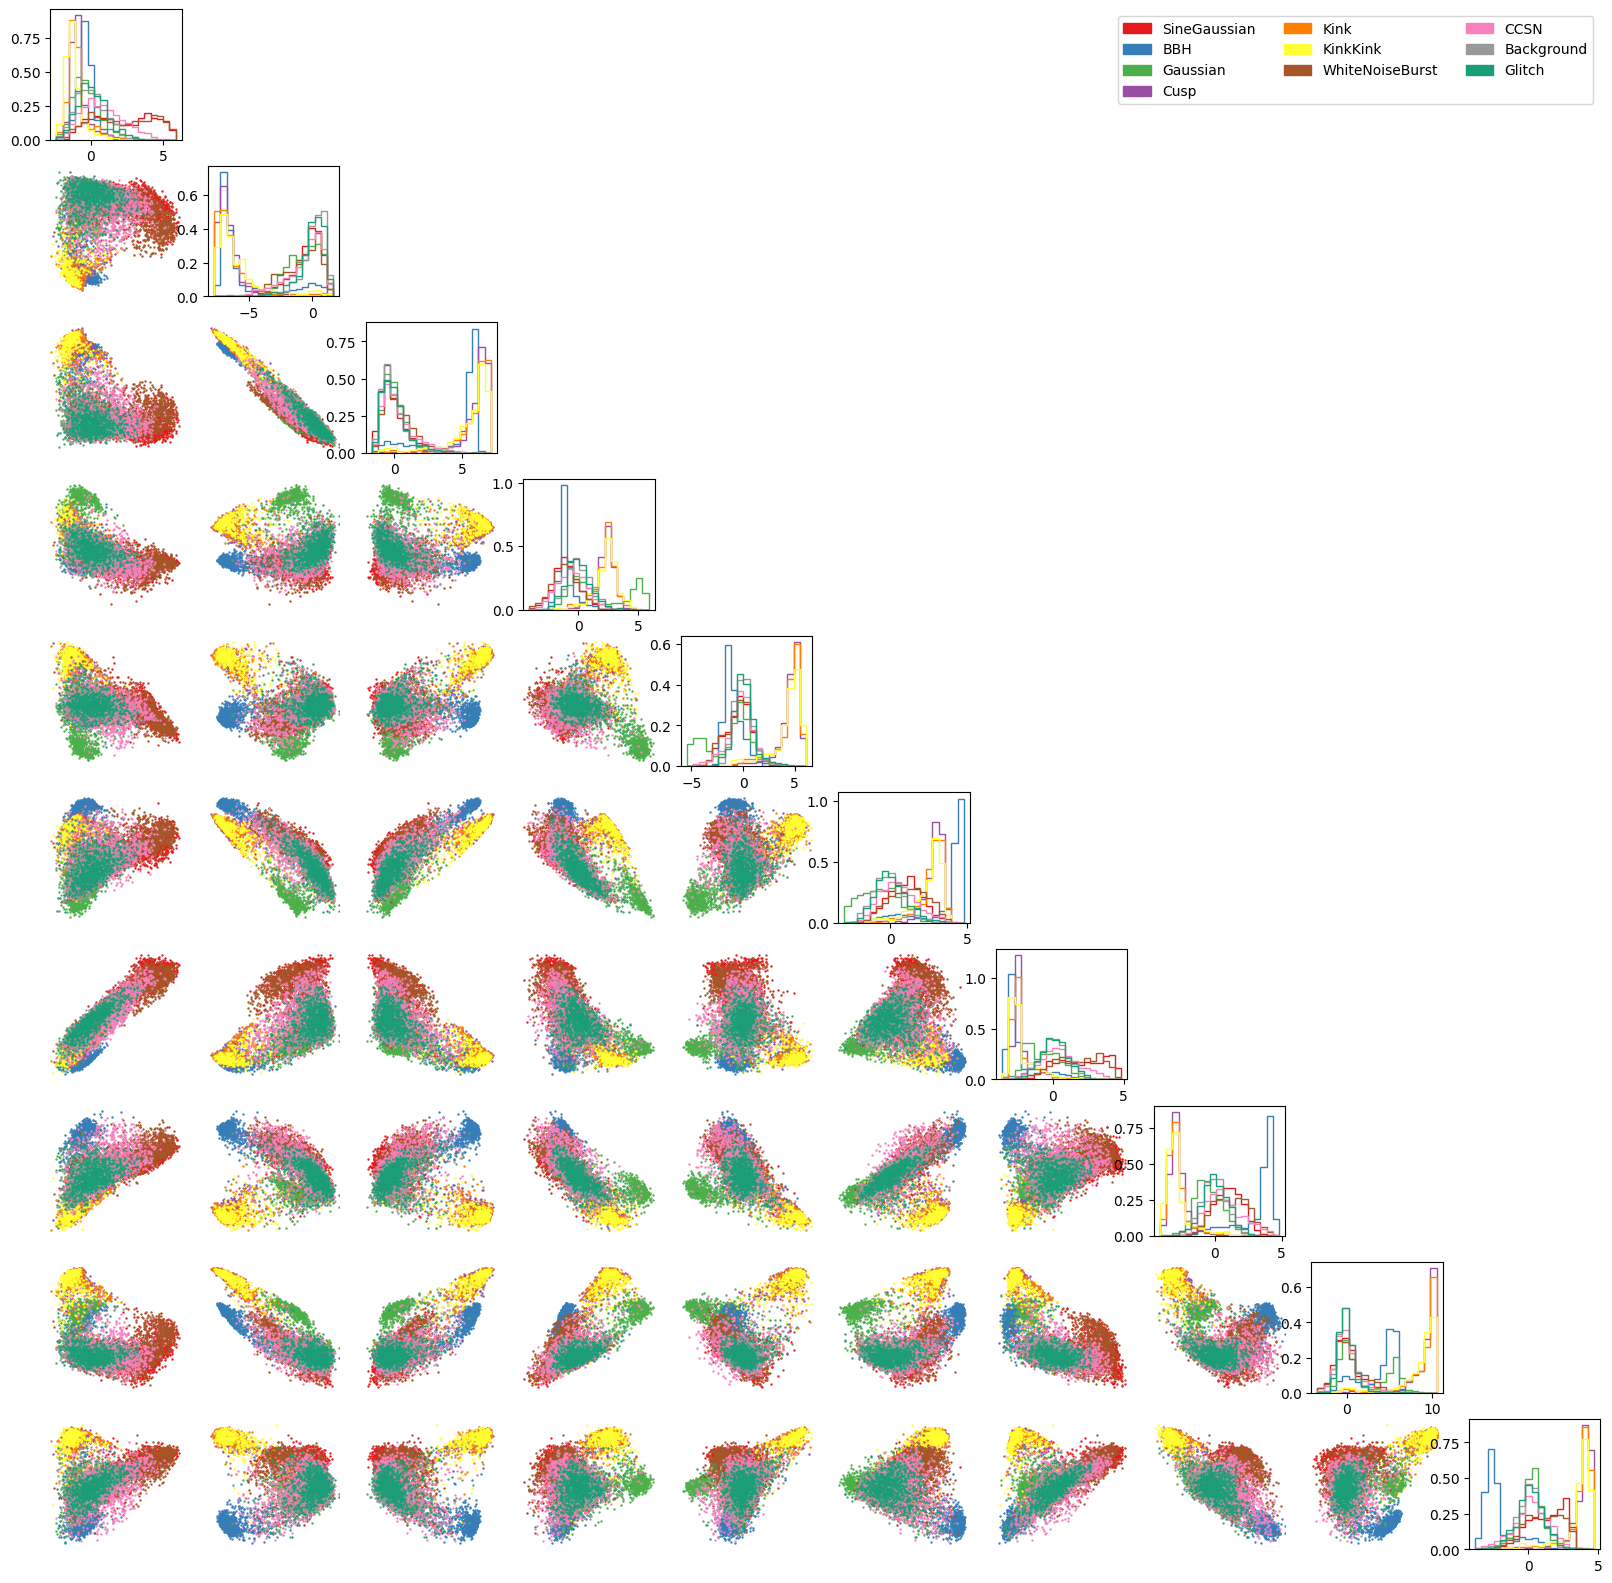

In [136]:
from plotting import make_corner
label_names = {i+1:loader.signal_classes[i] for i in range(len(loader.signal_classes))}
make_corner(space,labels,label_names)

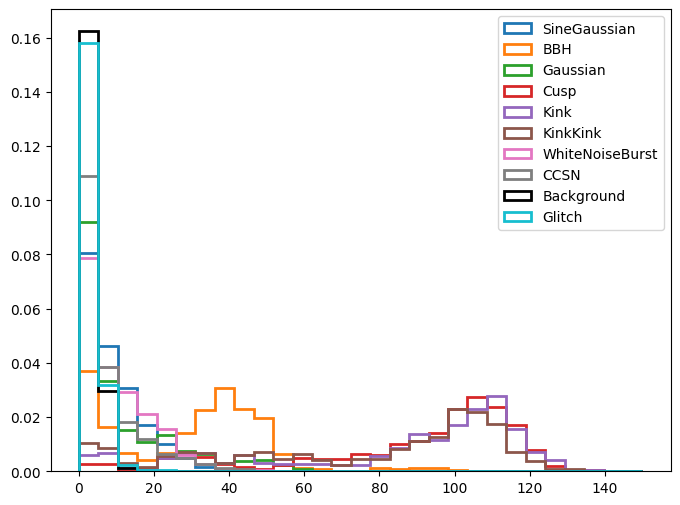

In [140]:
plt.figure(figsize=(8,6))
bins = np.linspace(0,150,30)
for i in range(len(loader.signal_classes)):
    sel = log_probs[labels==i+1]
    lab = loader.signal_classes[i]
    if lab == "Background":
        h = plt.hist(sel,bins=bins,label=lab,density=True,histtype='step',lw=2,color='k')
    else:
        h = plt.hist(sel,bins=bins,label=lab,density=True,histtype='step',lw=2,color=f"C{i}")
plt.legend()
#plt.yscale('log')

In [121]:
set(labels)

{1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0}